In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import logging

%matplotlib inline
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
import xgboost as xgb

#warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Descarga Datos desde Kaggle

In [44]:
#https://www.kaggle.com/datasets/luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!kaggle datasets download -d luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!unzip valor-casas-usadas-chile-rm-08032023.zip

In [45]:
'''-Price_CLP: Precio de casa en pesos chilenos (CLP)
-Price_UF: Precio de casa en unidades de fomento (UF)
-Price_USD: Precio de casa en dolares americanos (USD)
-Comuna: Comuna en la que se encuentra la casa.
-Ubicacion: Ubicación más específica de la casa
-Dorms: Cuantas habitaciones tiene la casa
-Baths: Cuantos baños tiene la casa
-Built Area: Cuantos metros cuadrados construidos tiene la casa
-Total Area: Cuantos metros cuadrados tiene toda la propiedad
-Parking: Cuantos estacionamentos tiene la casa
-id: Codigo de la casa en https://chilepropiedades.cl/ ; Ej: https://chilepropiedades.cl/ver-publicacion/11607213
-Realtor: El corredor de bienes raíces'''

'-Price_CLP: Precio de casa en pesos chilenos (CLP)\n-Price_UF: Precio de casa en unidades de fomento (UF)\n-Price_USD: Precio de casa en dolares americanos (USD)\n-Comuna: Comuna en la que se encuentra la casa.\n-Ubicacion: Ubicación más específica de la casa\n-Dorms: Cuantas habitaciones tiene la casa\n-Baths: Cuantos baños tiene la casa\n-Built Area: Cuantos metros cuadrados construidos tiene la casa\n-Total Area: Cuantos metros cuadrados tiene toda la propiedad\n-Parking: Cuantos estacionamentos tiene la casa\n-id: Codigo de la casa en https://chilepropiedades.cl/ ; Ej: https://chilepropiedades.cl/ver-publicacion/11607213\n-Realtor: El corredor de bienes raíces'

### 1. Carga CSV

Primero, se carga la base de datos de propiedades en un dataframe denominado **df_casas** como se parecia a continuación.

In [46]:
df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

Se desplegará la información general del dataset cargado. Se aprecia que se tienen variables de tipo numéricas y catergoricas que contienen datos nulos, por lo tanto, se debe analizar la importancia a priori de cada variable para determinar que hacer con los datos faltantes de las variables relevantes.

In [47]:
df_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9291 entries, 0 to 9290
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price_CLP   9291 non-null   int64  
 1   Price_UF    9291 non-null   float64
 2   Price_USD   9291 non-null   float64
 3   Comuna      9291 non-null   object 
 4   Ubicacion   9291 non-null   object 
 5   Dorms       9202 non-null   float64
 6   Baths       9138 non-null   float64
 7   Built Area  9013 non-null   float64
 8   Total Area  9057 non-null   float64
 9   Parking     6371 non-null   float64
 10  id          9291 non-null   int64  
 11  Realtor     8125 non-null   object 
dtypes: float64(7), int64(2), object(3)
memory usage: 871.2+ KB


### 2. Análisis a priori de variables relevantes
El objetivo de este trabajo es analizar patrones en las características intrínsecas de una propiedad para obtener algún modelo de tipo supervisado o no supervisado que permita realizar inferencias útiles en el ámbito inmobiliario. Por esto, en una primera instancia se descartan las variables **id** y **Realtor** de la base de datos. Por otra parte, la columna **Ubicacion** podría constituir una valiosa fuente de información, ya que, junto con la comuna potencialmente permitirían georreferenciar las propiedades, no obstante, las ubicaciones tienen datos generales que no permiten llevar a cabo la tarea descrita. Luego, este campo también se omitirá de las variables relevantes.

In [48]:
n_sample = 10
print("Ejemplo de valores del campo Ubicacion")
display(df_casas['Ubicacion'].sample(n=n_sample))

Ejemplo de valores del campo Ubicacion


1764               PasajeElSereno1561
1183                    RenatoZanelli
5609                       LoBascuñan
3512                      Uruguay9062
4699    VentaCasa3DormitoriosElBosque
5186                            Maipú
4058                     PuntadeDamas
2448                    Hiroshima1296
5168                    Chopin/Mozart
8154                        Santaines
Name: Ubicacion, dtype: object

Se observa que se tienen tres columnas sin datos nulos que apuntan al precio de la propiedad. Para este análisis, se escoge el precio en UF de las propiedades, debido a que es generalmente la moneda en que se transan este tipo de bienes, por lo tanto, los otros precios se omiten de los pasos posteriores. Finalmente, en este análisis a priori se escogen las siguientes variables para continuar con el análisis: **Price_UF, Comuna, Dorms, Baths, Built Area, Total Area** y **Parking**.

In [49]:
columns_filtered_priori = ['Price_UF', 'Comuna', 'Dorms', 'Baths', 'Built Area', 'Total Area', 'Parking']

### 3. Análisis Exploratorio de Datos
Como comienzo de este análisis se tratarán los datos faltantes. Para esto se estudiarán las estadísticas básicas de cada una de las variables numéricas y se compararán con las estadísticas básicas del dataset sin datos faltantes.

In [50]:
df_casas_analysis = df_casas[[name for name in columns_filtered_priori if name != 'Comuna']].copy()
percentiles = [.01,.025, .1, .25, .5, .75, .9, .975, .99]

display(df_casas_analysis.describe(percentiles=percentiles).transpose())

,count,mean,std,min,1%,2.5%,10%,25%,50%,75%,90%,97.5%,99%,max
Price_UF,9291.0,10879.276827,11187.989790,1026.0,1469.0,1663.0,2300.0,3553.5,6500.0,14600.0,25000.0,39990.0,52000.0,135000.0
Dorms,9202.0,4.027059,1.661439,1.0,2.0,2.0,3.0,3.0,4.0,5.0,6.0,8.0,10.0,35.0
Baths,9138.0,2.749726,1.478629,1.0,1.0,1.0,1.0,2.0,3.0,3.0,5.0,6.0,7.0,29.0
Built Area,9013.0,6091.603462,527436.675278,1.0,43.0,50.0,66.0,90.0,131.0,209.0,348.0,600.0,930.0,50000000.0
Total Area,9057.0,890.977145,11291.403141,1.0,56.0,64.0,90.0,134.0,230.0,480.0,1093.2,5000.0,5900.0,720000.0
Parking,6371.0,2.682467,2.221227,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,9.0,12.0,26.0


Ahora se calculan las estadísticas básicas de la variables numéricas sin datos faltantes.

In [51]:
mask_is_nan = pd.Series(data=np.ones(df_casas_analysis.shape[0], ).astype(bool))
for name in df_casas_analysis.columns.values:
    mask_is_nan = mask_is_nan & ~df_casas_analysis[name].isna()
display(df_casas_analysis[mask_is_nan].describe(percentiles=percentiles).transpose())

,count,mean,std,min,1%,2.5%,10%,25%,50%,75%,90%,97.5%,99%,max
Price_UF,6143.0,11142.430409,10897.001742,1026.0,1524.0,1802.0,2384.0,3680.0,7000.0,15000.0,25000.0,39840.5,49946.40,135000.0
Dorms,6143.0,3.996581,1.420814,1.0,2.0,2.0,3.0,3.0,4.0,5.0,6.0,7.0,9.00,25.0
Baths,6143.0,2.826958,1.437228,1.0,1.0,1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.00,29.0
Built Area,6143.0,675.226274,34636.513140,1.0,45.0,50.0,68.0,90.0,132.0,204.0,340.0,580.0,784.06,2710000.0
Total Area,6143.0,824.152694,9927.753781,1.0,60.0,68.0,96.0,137.0,240.0,480.0,1059.8,5000.0,5595.00,678000.0
Parking,6143.0,2.703239,2.227387,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,9.0,12.00,26.0


Tomando en cuenta las estadísticas básicas, se observa que las características que sufren mayores cambios en la media, desviación estándar y máximo son **Built Area** y **Total Area**, sin embargo, no se observan variaciones importantes en los percentiles calculados lo cual indica que la eliminación de los datos faltantes no afecta en mayor medida a la distribución general de las variables. Dado esto, se cree que es una buena opción la eliminación de los datos faltantes para el análisis posterior, ya que, se eliminan valores extremos que no afectan mayormente a la distribución original de las variables, simplemente afectan a los estadísticos básicos que son suceptibles a dichos valores. A continuación, se muestra el contraste gráfico de las distribuciones con y sin datos faltantes.

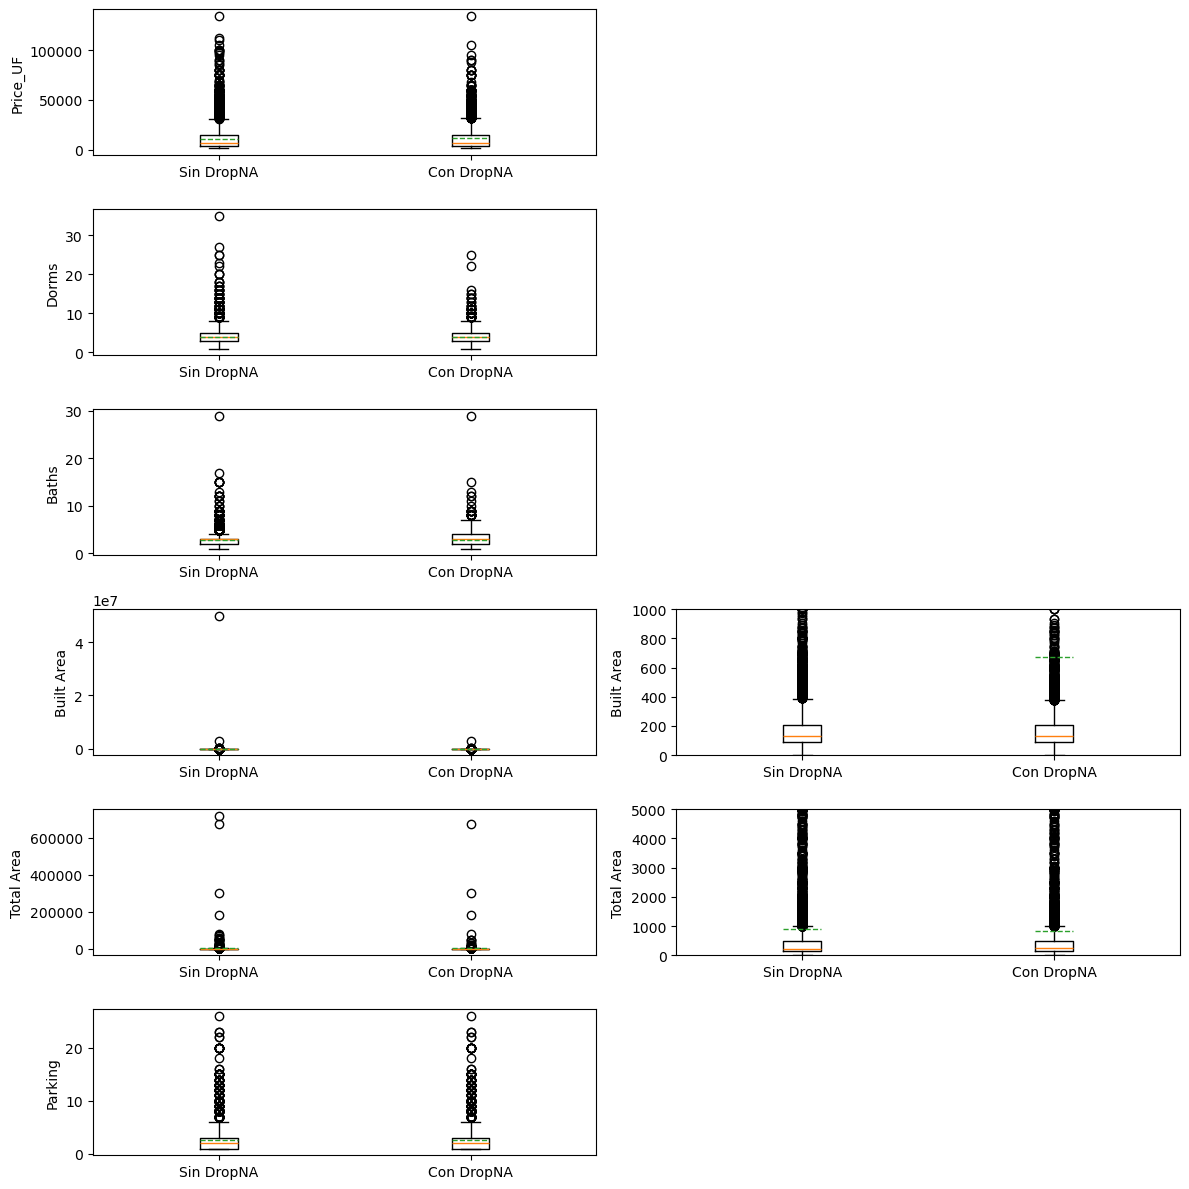

In [52]:
fig, axs = plt.subplots(nrows=df_casas_analysis.shape[1], ncols=2, 
                        figsize=(2 * df_casas_analysis.shape[1], 2 * df_casas_analysis.shape[1]), tight_layout=True)

labels = ['Sin DropNA', 'Con DropNA']

for i, column in enumerate(df_casas_analysis.columns.values):
    data_boxplot = [df_casas_analysis[column].dropna().values, df_casas_analysis[column][mask_is_nan].values]
    axs[i, 0].boxplot(data_boxplot, labels=labels, showmeans=True, meanline=True)
    axs[i, 0].set_ylabel(column)
    
    if column in ['Built Area', 'Total Area']:
        axs[i, 1].boxplot(data_boxplot, labels=labels, showmeans=True, meanline=True)
        axs[i, 1].set_ylabel(column)
        if column == 'Total Area':
            axs[i, 1].set_ylim([.0, 5. * 10 ** 3])
        else:
            axs[i, 1].set_ylim([.0, 10 ** 3])
    else:
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])
        axs[i, 1].axis('off')

plt.show()

Como se enunció anteriormente, los boxplot muestran que no hay cambios drásticos en las distribuciones de las características al eliminar los valores faltantes. El cambio más drástico se aprecia en el promedio de la característica **Built Area**, sin embargo, esto es normal debido a que el promedio es un estadístico sensible a los datos extremos. 

De los gráficos anteriores se aprecia que la gran mayoría de las variables poseen outliers considerando el criterio del rango intercuartílico, sin embargo, para este caso se clasificarán como atípicos los valores que se encuentren por sobre el percentil 99%.

In [53]:
stats_filtered = df_casas_analysis[mask_is_nan].describe(percentiles=percentiles).transpose()
p_threshold = 99
mask_outliers = mask_is_nan.copy()
for i, column in enumerate(df_casas_analysis.columns.values):
    mask_outliers = mask_outliers & (df_casas_analysis[column] <= stats_filtered[str(p_threshold) + '%'].iloc[i])

A continuación se muestra un contraste entre las distribuciones de cada característica con y sin el filtrado de outliers.

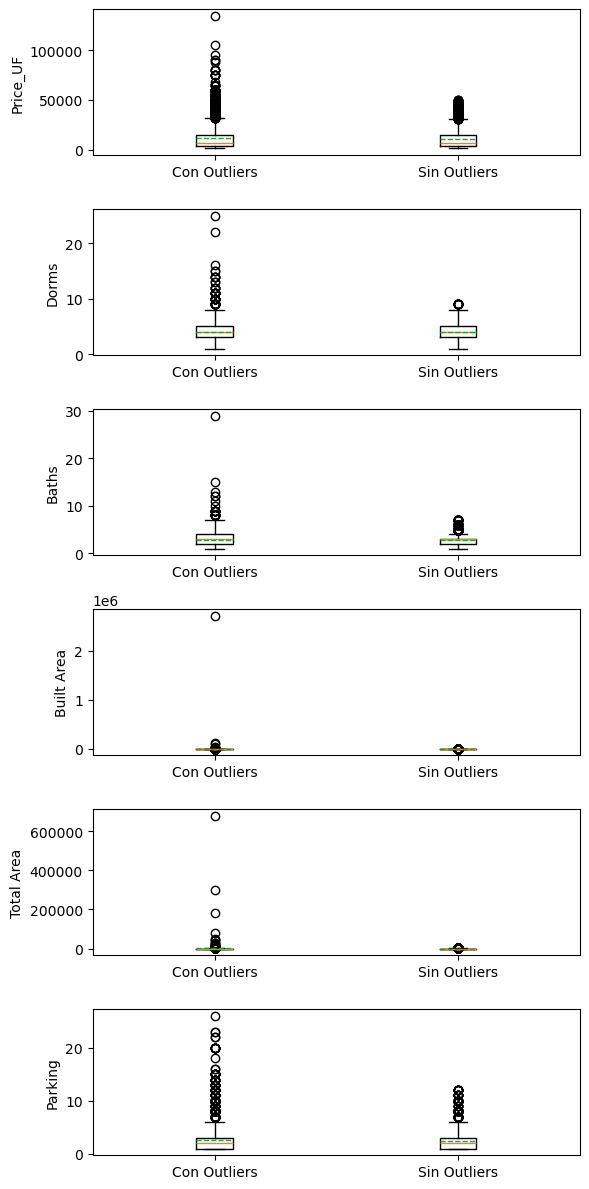

In [54]:
fig, axs = plt.subplots(nrows=df_casas_analysis.shape[1], ncols=1, 
                        figsize=(df_casas_analysis.shape[1], 2 * df_casas_analysis.shape[1]), tight_layout=True)

labels = ['Con Outliers', 'Sin Outliers']

for i, column in enumerate(df_casas_analysis.columns.values):
    data_boxplot = [df_casas_analysis[column][mask_is_nan].values, df_casas_analysis[column][mask_outliers].values]
    axs[i].boxplot(data_boxplot, labels=labels, showmeans=True, meanline=True)
    axs[i].set_ylabel(column)

plt.show()

Ahora se analizará si existen variables redundantes según el criterio de correlación. Para esto, a continuación, se calcula la correlación entre cada una de las variables.

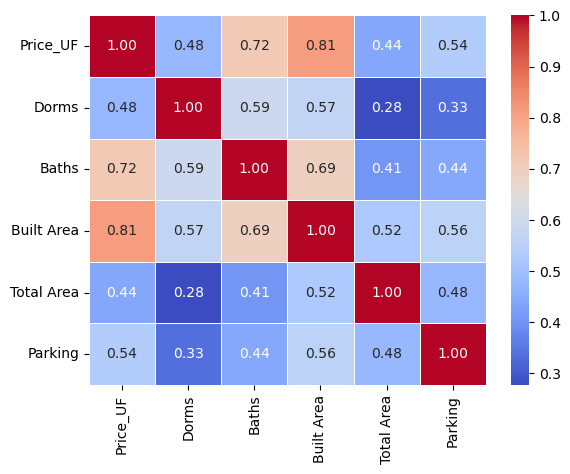

In [55]:
sns.heatmap(df_casas_analysis[mask_outliers].corr(), annot=True,fmt=".2f", cmap='coolwarm',linewidths=0.5)
plt.show()

Se aprecia que las variables que los pares de variables que se encuentran más correlacionados son **Price_UF - Baths**, **Price_UF - Built Area** y **Built Area - Baths**, sin embargo, a pesar de que esto es un resultado esperable se cree que los valores de correlación, no son lo suficientemente altos para asumir una redundancia lineal entre estas variables. Luego, no se elimina ninguna variable por correlación.

En lo que sigue se analizan las distribuciones de las variables finales escogidas para escoger el escalamiento más adecuado debido a su comportamiento.

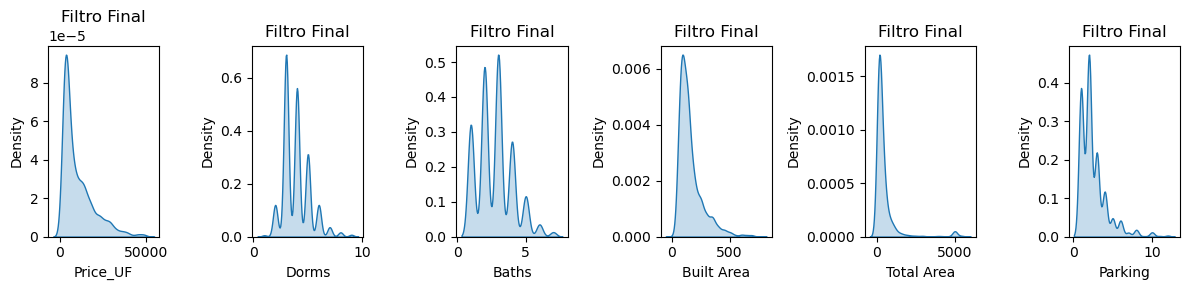

In [56]:
fig, axs = plt.subplots(nrows= 1, ncols=df_casas_analysis.shape[1], figsize=(12, 3), tight_layout=True)

for j, column in enumerate(df_casas_analysis.columns.values):
    axs[j] = sns.kdeplot(data=df_casas_analysis[mask_outliers], x=column, ax=axs[j], fill=True)
    axs[j].set_xlabel(column)
    axs[j].set_title('Filtro Final')

Dadas las distribuciones obtenidas, se aprecia que las variables **Price_UF, Built Area, Total Area** y **Parking** tienen funciones de densidad de kernel similares a una distribución **log-normal**, por esto, se aplica una transformación de este tipo a estas variables para estudiar su comportamiento.

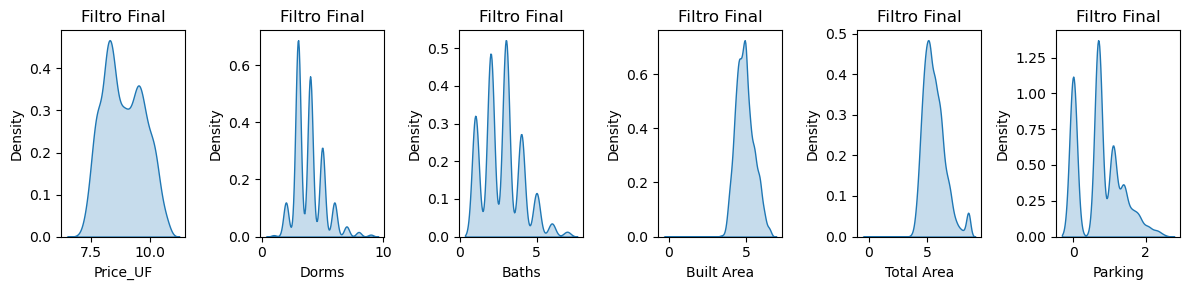

In [57]:
df_casas_transformed = df_casas_analysis[mask_outliers].copy()
df_casas_transformed['Price_UF'][mask_outliers] = np.log(df_casas_transformed['Price_UF'])
df_casas_transformed['Built Area'][mask_outliers] = np.log(df_casas_transformed['Built Area'])
df_casas_transformed['Total Area'][mask_outliers] = np.log(df_casas_transformed['Total Area'])
df_casas_transformed['Parking'][mask_outliers] = np.log(df_casas_transformed['Parking'])

fig, axs = plt.subplots(nrows= 1, ncols=df_casas_transformed.shape[1], figsize=(12, 3), tight_layout=True)

for j, column in enumerate(df_casas_transformed.columns.values):
    axs[j] = sns.kdeplot(data=df_casas_transformed, x=column, ax=axs[j], fill=True)
    axs[j].set_xlabel(column)
    axs[j].set_title('Filtro Final')

Si bien existen distribuciones irregulares se aprecia que en general tienen tendencia a centralizarse alrededor de un valor, por lo tanto, se utilizará un escalimiento de tipo **StandardScaler**.

In [58]:
scaler = StandardScaler().fit(df_casas_transformed)
df_scaled = pd.DataFrame(data=scaler.transform(df_casas_transformed), columns=df_casas_transformed.columns.values)
display(df_scaled)

,Price_UF,Dorms,Baths,Built Area,Total Area,Parking
0,-0.809950,-0.742971,-0.573306,-1.167756,-0.189386,-1.248681
1,-0.808973,0.907361,0.206649,0.201733,-0.350182,-0.071610
2,-0.474079,0.082195,0.206649,-0.682537,-0.395948,0.616932
3,-0.762116,-0.742971,-0.573306,-0.781482,-0.437675,-1.248681
4,-0.333760,-0.742971,0.206649,-0.045983,0.447131,-1.248681
...,...,...,...,...,...,...
5898,-2.052233,0.082195,-1.353261,-2.175097,-1.257233,-1.248681
5899,-0.241055,-0.742971,-0.573306,0.143047,-0.071054,1.105461
5900,-1.266166,0.082195,-1.353261,-2.175097,-1.541628,-1.248681
5901,-1.377990,-1.568136,-1.353261,-0.998146,-1.033047,-0.071610


Por último, se procede a codificar las categorías de la variable comuna y se agregan al dataframe final de trabajo.

In [59]:
encoder = OneHotEncoder()
code_data = encoder.fit_transform(df_casas['Comuna'][mask_outliers].values.reshape(-1, 1)).toarray()
X = pd.concat([df_scaled, pd.DataFrame(code_data, columns = encoder.categories_[0])], axis = 1)
y_transformed = X['Price_UF']
y_original = df_casas['Price_UF'][mask_outliers]
X.drop(columns=['Price_UF'], inplace=True)
display(X)

,Dorms,Baths,Built Area,Total Area,Parking,Buin,CaleradeTango,Cerrillos,CerroNavia,Colina,Conchalí,Curacaví,ElBosque,ElMonte,EstaciónCentral,Huechuraba,Independencia,IsladeMaipo,LaCisterna,LaFlorida,LaGranja,LaPintana,LaReina,Lampa,LasCondes,LoBarnechea,LoEspejo,LoPrado,Macul,Maipú,MaríaPinto,Melipilla,PadreHurtado,Paine,PedroAguirreCerda,Peñaflor,Peñalolén,Pirque,Providencia,Pudahuel,PuenteAlto,Quilicura,QuintaNormal,Recoleta,Renca,SanBernardo,SanJoaquín,SanJosédeMaipo,SanMiguel,SanRamón,Santiago,Talagante,Tiltil,Vitacura,Ñuñoa
0,-0.742971,-0.573306,-1.167756,-0.189386,-1.248681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.907361,0.206649,0.201733,-0.350182,-0.071610,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.082195,0.206649,-0.682537,-0.395948,0.616932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.742971,-0.573306,-0.781482,-0.437675,-1.248681,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.742971,0.206649,-0.045983,0.447131,-1.248681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5898,0.082195,-1.353261,-2.175097,-1.257233,-1.248681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5899,-0.742971,-0.573306,0.143047,-0.071054,1.105461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5900,0.082195,-1.353261,-2.175097,-1.541628,-1.248681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5901,-1.568136,-1.353261,-0.998146,-1.033047,-0.071610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Modelo de Regresion

A continuación se procede a probar diferentes modelos de regresión con múltiples hiperparámetros, combinado validación cruzada con el objetivo de encontrar el modelo que tenga el mejor ajuste. Asimismo se definieron las siguientes métricas: R2, R2 ajustado, MSE, MAE.

In [60]:
def modelos_regresion (X,y):
    #Se particionan los datos en entrenamiento y testeo
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
    
    #Se realiza escalado de datos

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #Se definen los siguientes modelos de regresión con los respectivos hiperparámetros
    models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
                            }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9],
            'fit_intercept': [True, False]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'absolute_error','friedman_mse']
        }
    },

    'KNeighborsRegressor':{
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors':[3,5,6,10],
            'weights':['uniform','distance'],
            'metric':['cosine','euclidean','manhattan']
        }

    },
    'GradientBoostingRegressor':{
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'friedman_mse']
        }

    },
    'XGBoostRegressor':{
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'params': {'n_estimators': [100, 300],
                   'learning_rate': [0.01, 0.1],
                   'max_depth': [3, 5, 7],
                   'subsample': [0.7, 0.8],
                   'colsample_bytree': [0.8],
                   'min_child_weight': [1, 3],
                   'reg_alpha': [0, 0.1],
                   'reg_lambda': [0.1, 0.5]
        }
    }
    
}
    # Se definen las siguientes métricas de evaluación
    scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'}

    results=[]

    #Se realiza un GridSearchCV para cada modelo probando con diferentes hiperparámetros y una validación cruzada de 5 folds
    for model_name, model in models.items():

        grid = GridSearchCV(model['model'], model['params'], cv=5, scoring=scoring,n_jobs=-1,refit='R2')
        grid.fit(X_train, y_train)
        logging.info(f'Modelo {model_name} terminado')

        #Se guardan los resultados en un DataFrame
        results.append({
            'Modelo': model_name,
            'Best_Estimator': grid.best_estimator_,
            'Best_Params': grid.best_params_,
            'Best_R2_Score': grid.best_score_,
            'Best_MAE': -grid.cv_results_['mean_test_MAE'][grid.best_index_],  
            'Best_MSE': -grid.cv_results_['mean_test_MSE'][grid.best_index_] })

    results_df=pd.DataFrame(results)

    #Se calcula el R2 Ajustado
    lista=[]
    for i in results_df['Best_R2_Score'].values:
        lista.append((1-((X.shape[0]-1)/(X.shape[0]-X.shape[1]-1))*(1-i)))
        
    results_df['R2 Ajustado']=lista
    
    return results_df


#### 4.1 Aplicación Modelo de regresion sin Comunas

In [61]:
X_sin_comunas=X.iloc[:, 0:5].values
y_sin_comunas=y_transformed.values

df_sin_comunas=modelos_regresion(X_sin_comunas,y_sin_comunas)
df_sin_comunas

INFO:root:Modelo LinearRegression terminado
INFO:root:Modelo ElasticNet terminado
INFO:root:Modelo Ridge terminado
INFO:root:Modelo Lasso terminado
INFO:root:Modelo DecisionTree terminado
INFO:root:Modelo RandomForest terminado
INFO:root:Modelo KNeighborsRegressor terminado
INFO:root:Modelo GradientBoostingRegressor terminado
INFO:root:Modelo XGBoostRegressor terminado


,Modelo,Best_Estimator,Best_Params,Best_R2_Score,Best_MAE,Best_MSE,R2 Ajustado
0,LinearRegression,LinearRegression(fit_intercept=False),{'fit_intercept': False},0.768746,0.367432,0.231535,0.768550
1,ElasticNet,"ElasticNet(alpha=0.1, fit_intercept=False, l1_...","{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",0.765049,0.374804,0.235181,0.764849
2,Ridge,"Ridge(alpha=10, fit_intercept=False)","{'alpha': 10, 'fit_intercept': False}",0.768758,0.367518,0.231522,0.768561
3,Lasso,"Lasso(alpha=0.1, fit_intercept=False)","{'alpha': 0.1, 'fit_intercept': False}",0.752601,0.393640,0.247660,0.752391
4,DecisionTree,DecisionTreeRegressor(criterion='friedman_mse'),"{'criterion': 'friedman_mse', 'splitter': 'best'}",0.661277,0.418469,0.338857,0.660990
5,RandomForest,(DecisionTreeRegressor(criterion='absolute_err...,"{'criterion': 'absolute_error', 'n_estimators'...",0.814068,0.315469,0.186218,0.813910
6,KNeighborsRegressor,"KNeighborsRegressor(metric='manhattan', n_neig...","{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.817279,0.314125,0.183044,0.817124
7,GradientBoostingRegressor,"([DecisionTreeRegressor(max_depth=3,\n ...","{'criterion': 'squared_error', 'n_estimators':...",0.826258,0.308613,0.174106,0.826110
8,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.827499,0.308847,0.172837,0.827352


#### 4.2 Aplicación Modelo de regresion con Comunas

In [62]:
X_con_comunas=X.values
y_con_comunas=y_transformed.values
df_con_comunas=modelos_regresion(X_con_comunas,y_con_comunas)
df_con_comunas


INFO:root:Modelo LinearRegression terminado
INFO:root:Modelo ElasticNet terminado
INFO:root:Modelo Ridge terminado
INFO:root:Modelo Lasso terminado
INFO:root:Modelo DecisionTree terminado
INFO:root:Modelo RandomForest terminado
INFO:root:Modelo KNeighborsRegressor terminado
INFO:root:Modelo GradientBoostingRegressor terminado
INFO:root:Modelo XGBoostRegressor terminado


,Modelo,Best_Estimator,Best_Params,Best_R2_Score,Best_MAE,Best_MSE,R2 Ajustado
0,LinearRegression,LinearRegression(fit_intercept=False),{'fit_intercept': False},0.808123,0.244489,0.189355,0.806318
1,ElasticNet,"ElasticNet(alpha=0.1, fit_intercept=False, l1_...","{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",0.886913,0.254883,0.113236,0.885849
2,Ridge,"Ridge(alpha=10, fit_intercept=False)","{'alpha': 10, 'fit_intercept': False}",0.896434,0.240411,0.103706,0.895460
3,Lasso,"Lasso(alpha=0.1, fit_intercept=False)","{'alpha': 0.1, 'fit_intercept': False}",0.790576,0.362048,0.209648,0.788606
4,DecisionTree,DecisionTreeRegressor(criterion='friedman_mse'...,"{'criterion': 'friedman_mse', 'splitter': 'ran...",0.843146,0.280744,0.156954,0.841670
5,RandomForest,(DecisionTreeRegressor(criterion='absolute_err...,"{'criterion': 'absolute_error', 'n_estimators'...",0.894403,0.225990,0.105885,0.893410
6,KNeighborsRegressor,"KNeighborsRegressor(metric='manhattan', n_neig...","{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.899886,0.224063,0.100234,0.898944
7,GradientBoostingRegressor,"([DecisionTreeRegressor(max_depth=3,\n ...","{'criterion': 'squared_error', 'n_estimators':...",0.900121,0.232629,0.100099,0.899181
8,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.916868,0.209747,0.083335,0.916087


In [63]:
print(f"Mejor Modelo sin comunas: {df_sin_comunas.loc[df_sin_comunas['R2 Ajustado'].idxmax()]['Modelo']}")
print(f"Mejor Modelo sin comunas mejores hiperparámetros: {df_sin_comunas.loc[df_sin_comunas['R2 Ajustado'].idxmax()]['Best_Params']}")
print("=======================================================================")
print(f"Mejor Modelo con comunas: {df_con_comunas.loc[df_con_comunas['R2 Ajustado'].idxmax()]['Modelo']}")
print(f"Mejor Modelo con comunas mejores hiperparámetros: {df_con_comunas.loc[df_con_comunas['R2 Ajustado'].idxmax()]['Best_Params']}")

Mejor Modelo sin comunas: XGBoostRegressor
Mejor Modelo sin comunas mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}
Mejor Modelo con comunas: XGBoostRegressor
Mejor Modelo con comunas mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}


### 5. Clusterización

A continuación se aplicará una clusterización de datos, con el objetivo de analizar los grupos de propiedades frente a las comunas de santiago. Para lo anterior, se utiliza la técnica `KMeans`.

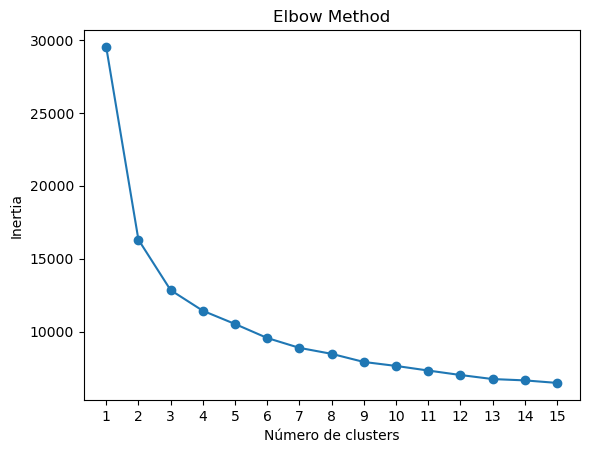

In [64]:
X_cluster = X.iloc[:,0:5] 
df_cluster = df_scaled.copy()
#### Variable de interés para comparar los clusters:
y = df_casas[mask_outliers]['Comuna']

### No se realiza reducción de dimensionalidad, ya que existen pocos atributos.

### A continuación se busca mediante el metodo del codo, el valor óptimo para los clusters

inertia=[]
for i in range(1,16):
    kmeans = KMeans(n_clusters=i,random_state=4431,max_iter=1000).fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,16),inertia,marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(np.arange(1,16,1))
plt.show()

In [65]:
#re-entrena con los 7 clusters, cuando ya se estabiliza la inercia
kmeans = KMeans(n_clusters=7,random_state=4431,max_iter=1000).fit(X_cluster)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

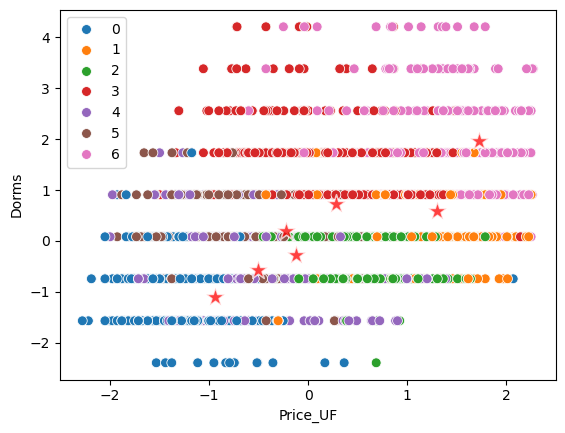

In [66]:
# grafico de dispersion entre precio y dorms y usando como hue los clusters y tambien dibujando sus centroides.
sns.scatterplot(x=df_cluster.iloc[:,0],y=df_cluster.iloc[:,1] ,hue=labels, s=50,palette='tab10')
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=200, alpha=0.75, marker='*')
plt.show()

In [67]:
# mapear al dataset original los clusters

df_cluster['Cluster']=labels
df_cluster['Comuna']=y.to_numpy()

#observar clusters y precios medios y cuenta de casas.
df_cluster.groupby('Cluster').agg({'Price_UF':['mean','std','count']})

Price_UF                
             mean       std count
Cluster                          
0       -1.197514  0.425744   963
1        1.184207  0.546198   572
2        0.410912  0.561151  1189
3        0.432694  0.700836   730
4       -0.533980  0.565271  1225
5       -0.454333  0.632078   767
6        1.474832  0.483917   457

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


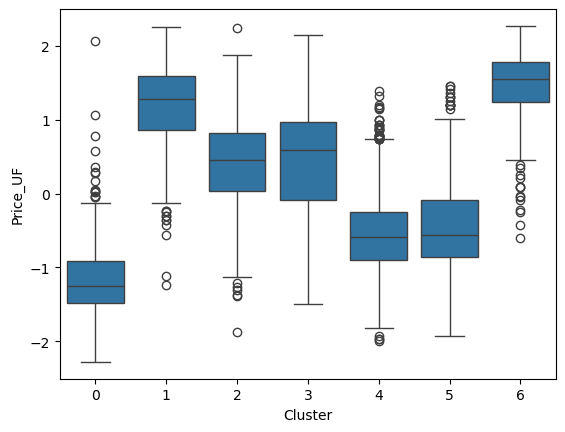

In [68]:
# Se observa la distribucion de precios mediante un boxplot para cada cluster
sns.boxplot(x='Cluster',y='Price_UF',data=df_cluster)
plt.show();

In [69]:
# Se genera dataframe agrupado por cluster y comuna para analizar la preponderancia de algunas comunas a los respectivos clusters
df_cluster_comuna=pd.DataFrame(df_cluster.groupby(by=['Cluster','Comuna']).agg({'Price_UF':['count']}).reset_index().values,columns=['cluster','comuna','cuenta'])

In [70]:
# Se ordena para poder extraer las top comunas de cada cluster
df_cluster_comuna=df_cluster_comuna.sort_values(by=['cluster','cuenta'],ascending=False)

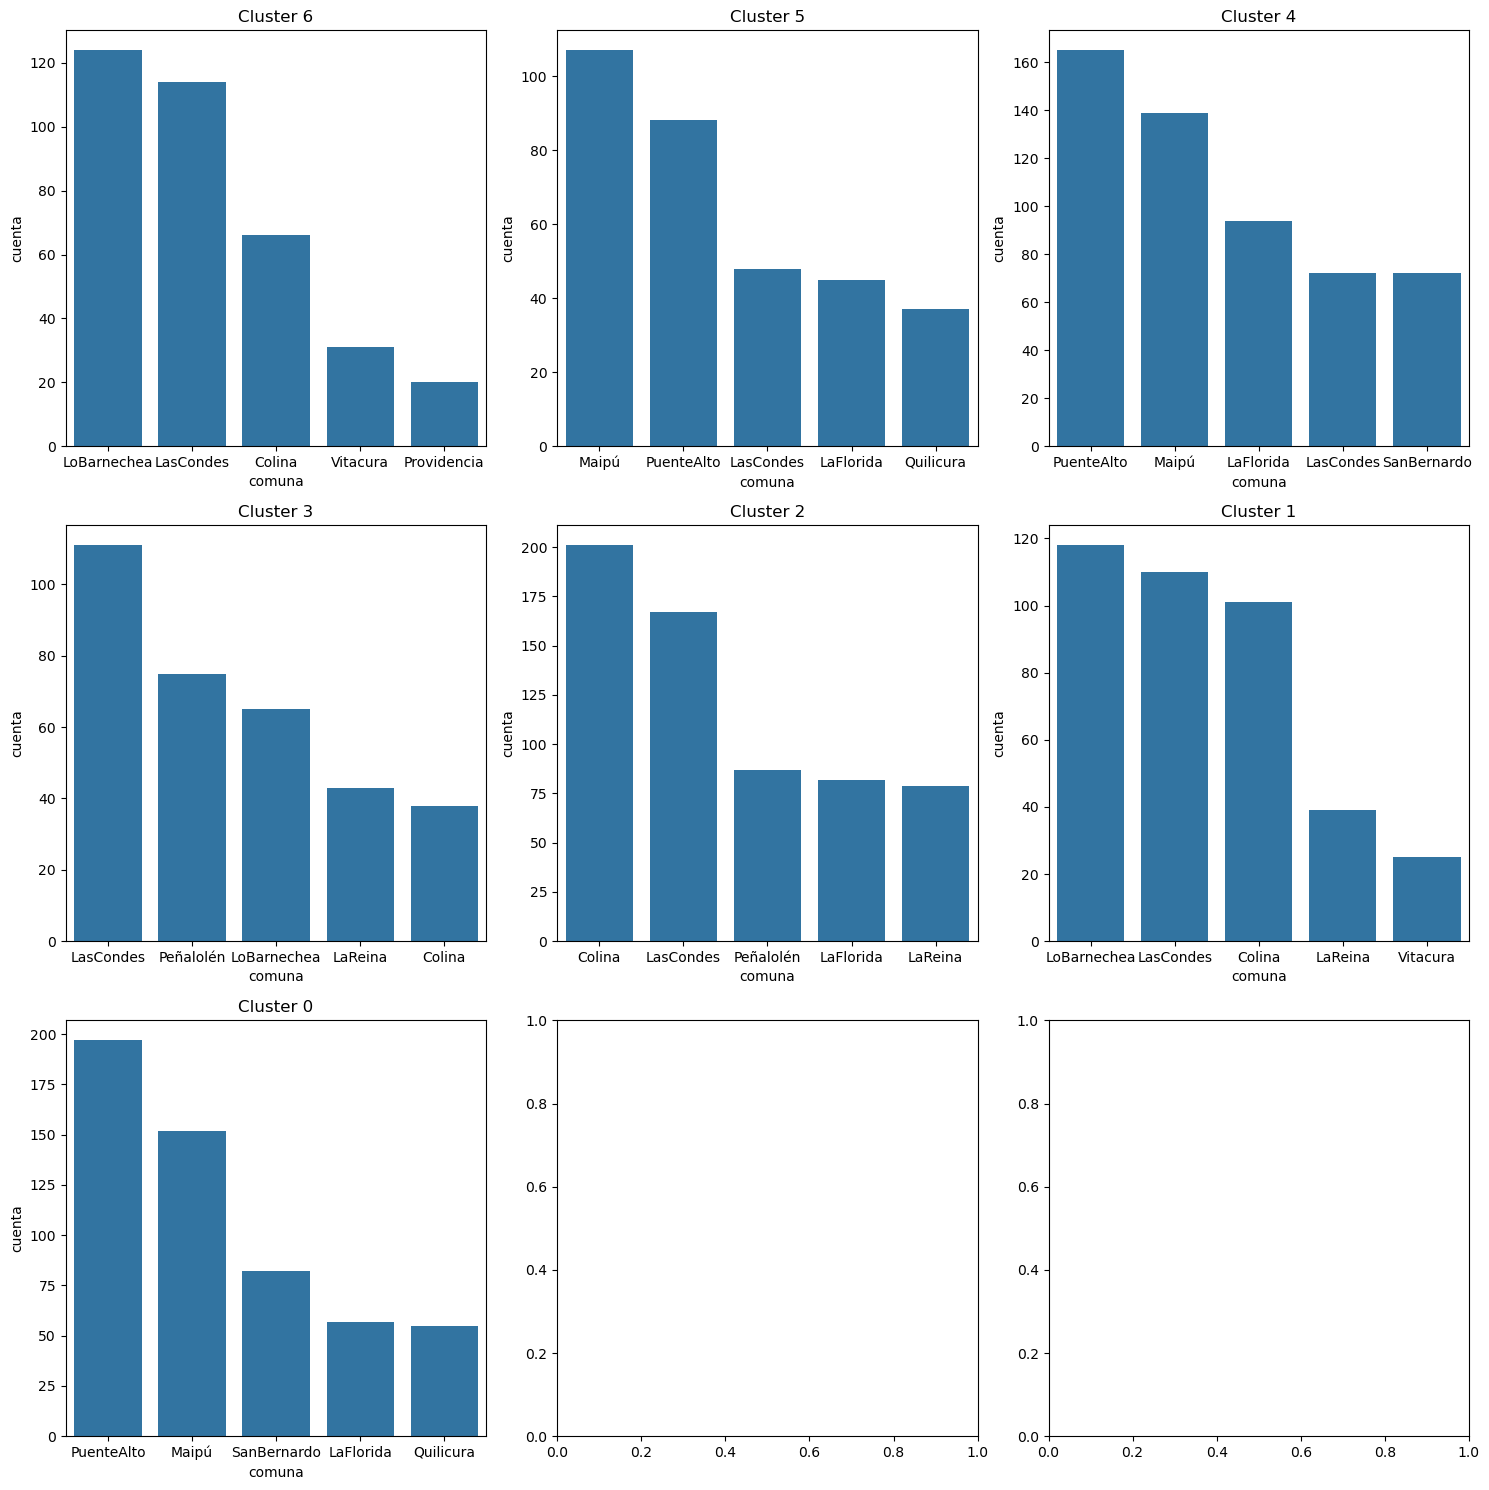

In [71]:
# Se Gráfica en una grilla las top comunas de cada cluster y la cantidad de veces que aparecen
ncols=3
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows),tight_layout=True)

axes = axes.flatten()  

for i,cluster_i in enumerate(df_cluster_comuna.cluster.unique()):
    df_cluster_comuna_i=df_cluster_comuna.query(f'cluster == {cluster_i}').head(5)
    sns.barplot(df_cluster_comuna_i, ax=axes[i],x='comuna',y='cuenta')
    axes[i].set_title(f'Cluster {cluster_i}')

#### **Clusterización de Variables usando K-Means - Versión antigua**

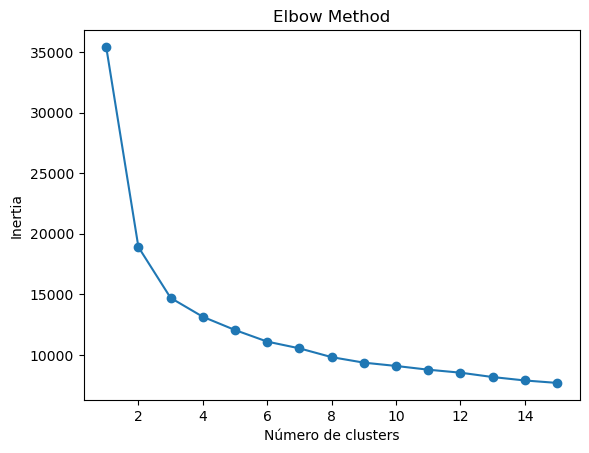

In [72]:
#leer los datos
# df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

# #preprocesamiento
# def preprocesamiento(df_original:pd.DataFrame)->pd.DataFrame:
# #     #Se eliminan NaNs y Outliers y se transforma la variable objetivo
#      df_original.dropna(how='any',inplace=True)
#      df_original=df_original[(df_original['Total Area']<250000) & (df_original['Built Area']<100000)]
#      df_original=df_original.drop(columns=['Ubicacion','id','Realtor','Price_CLP','Price_USD'],axis=1)
#      df_original['Price_UF'] = df_original['Price_UF'].apply(lambda x : np.log(x))
    
# #     #dummies de comunas

#      return df_original

#df_casas_preproc = preprocesamiento(df_casas)

# Vamos a hacer una clusteririzacion de los datos y observar si se pueden identificar grupos de propiedades y tambien si estos grupos se relacionan
# con las comunas de santiago
# Para ello vamos a utilizar KMeans para realizar una clusterizacion de los datos

X_cluster = df_casas_transformed
y = df_casas[mask_outliers]['Comuna']

sc=StandardScaler()
X_cluster_sc=sc.fit_transform(X_cluster)
df_cluster=pd.DataFrame(X_cluster_sc,columns=X_cluster.columns)

# No vamos a realizar una reducción de dimensionalidad ya que tenemos pocas columnas

#almacenamos la inercia para construir la grafica del codo, para la eleccion de clusters

inertia=[]
for i in range(1,16):
    kmeans = KMeans(n_clusters=i,random_state=4431,max_iter=1000).fit(X_cluster_sc)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,16),inertia,marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [73]:
#re-entrenamos con los 7 clusters, cuando ya se estabiliza la inercia
kmeans = KMeans(n_clusters=7,random_state=4431,max_iter=1000).fit(X_cluster_sc)

In [74]:
# extraemos labels de clusters y centroides
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

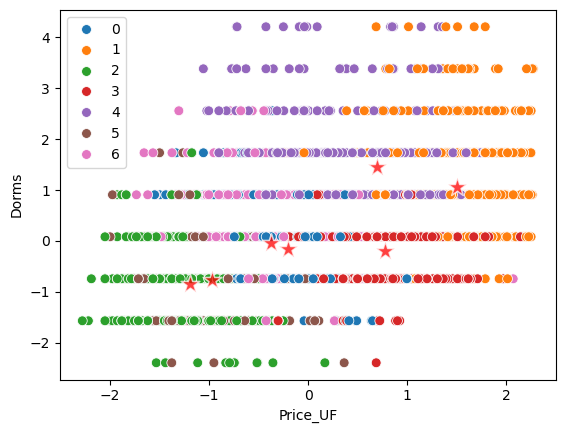

In [75]:
# dibujamos grafico de dispersion entre precio y dorms y usando como hue los clusters y tambien dibujando sus centroides.
sns.scatterplot(x=df_cluster.iloc[:,0],y=df_cluster.iloc[:,1] ,hue=labels, s=50,palette='tab10')
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=200, alpha=0.75, marker='*')
plt.show()


In [76]:
# mapear al dataset original los clusters

df_cluster['Cluster']=labels
df_cluster['Comuna']=y.to_numpy()

In [77]:
#observar clusters y precios medios y cuenta de casas.
df_cluster.groupby('Cluster').agg({'Price_UF':['mean','std','count']})

Price_UF                
             mean       std count
Cluster                          
0       -0.203424  0.469560  1250
1        1.500740  0.417372   717
2       -1.198105  0.389743   925
3        0.777282  0.427491   973
4        0.693615  0.576052   656
5       -0.965948  0.409821   685
6       -0.377526  0.557549   697

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


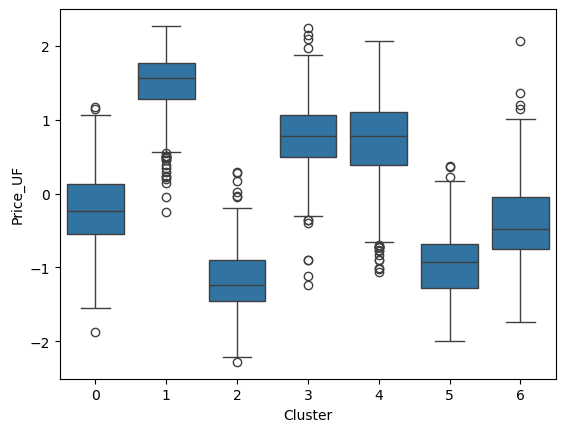

In [78]:
# Observemos la distribucion de precios mediante un boxplot para cada cluster
sns.boxplot(x='Cluster',y='Price_UF',data=df_cluster)
plt.show()

In [79]:
# generemos un dataframe agrupado por cluster y comuna para analizar la preponderancia de algunas comunas a los respectivos clusters
df_cluster_comuna=pd.DataFrame(df_cluster.groupby(by=['Cluster','Comuna']).agg({'Price_UF':['count']}).reset_index().values,columns=['cluster','comuna','cuenta'])

In [80]:
# ordenamos para poder extraer las top comunas de cada cluster
df_cluster_comuna=df_cluster_comuna.sort_values(by=['cluster','cuenta'],ascending=False)

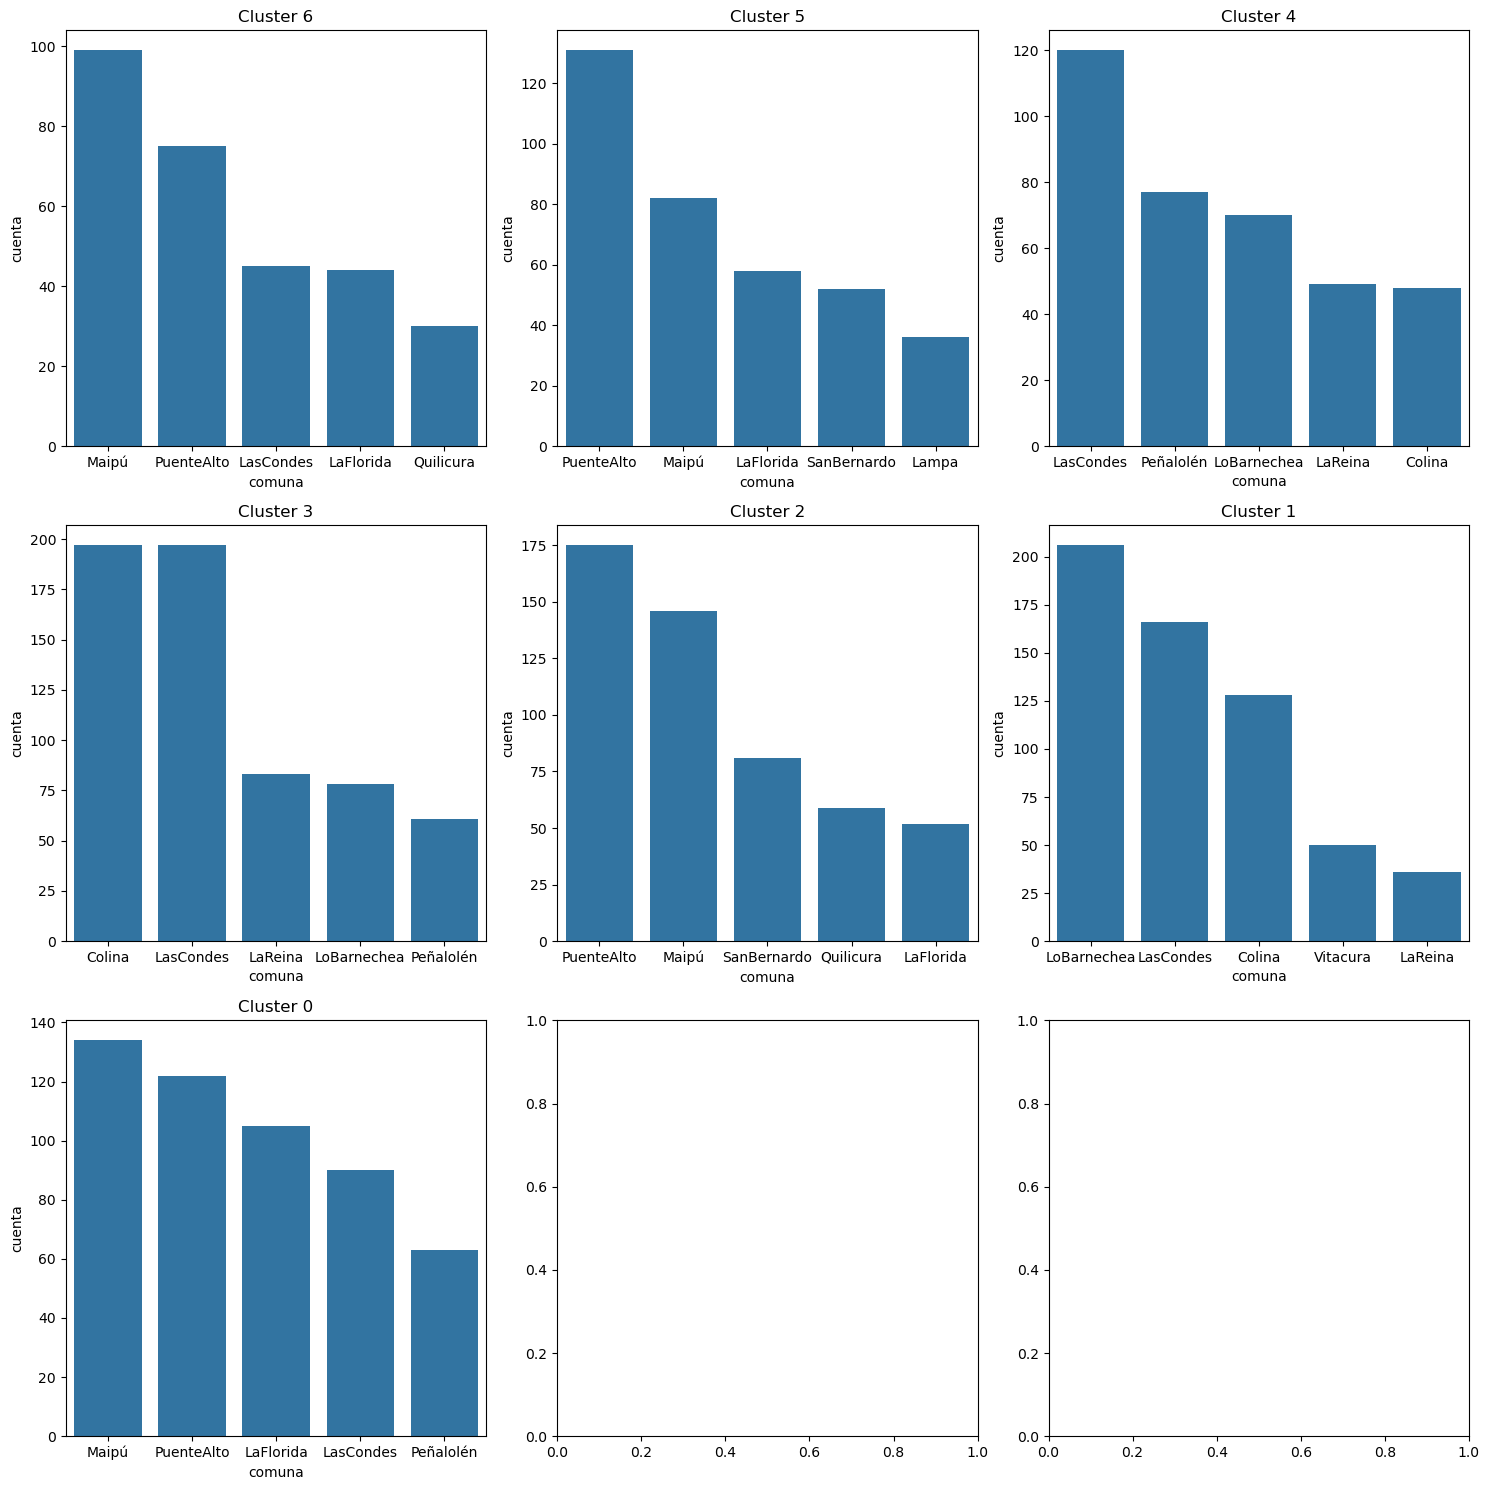

In [81]:
# graficamos en una grilla las top comunas de cada cluster y la cantidad de veces que aparecen
ncols=3
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows),tight_layout=True)

axes = axes.flatten()  

for i,cluster_i in enumerate(df_cluster_comuna.cluster.unique()):
    df_cluster_comuna_i=df_cluster_comuna.query(f'cluster == {cluster_i}').head(5)
    sns.barplot(df_cluster_comuna_i, ax=axes[i],x='comuna',y='cuenta')
    axes[i].set_title(f'Cluster {cluster_i}')